# **Binary Image Classification (Drone-Vs-Bird)**

#STEP 1: Setup Kaggle in Colab

In [ ]:
!mkdir -p ~/.kaggle
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


# STEP 2: Download Dataset & Unzip:

In [ ]:
# !kaggle datasets download -d harshwalia/birds-vs-drone-dataset -p ./ --unzip
!kaggle datasets download -d muhammadsaoodsarwar/drone-vs-bird -p ./ --unzip

Dataset URL: https://www.kaggle.com/datasets/muhammadsaoodsarwar/drone-vs-bird
License(s): apache-2.0
 99% 1.58G/1.59G [00:23<00:00, 26.9MB/s]
100% 1.59G/1.59G [00:23<00:00, 73.5MB/s]


#STEP 1: Import Libraries

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, BatchNormalization, Dropout

# Conv2D --> Applies convolution filters to extract image features (edges, shapes).
# MaxPool2D --> Reduces image size while keeping important information.
# Flatten --> Converts 2D feature maps → 1D vector for Dense layers.
# Dense --> Fully connected layers.


---
  * Batch size : the model processes images in batches, not all at once.

  * updates weights after each batch.

  `How training happens in ONE EPOCH:`

  Batch	   --->    Images processed

Batch 1	   --->     Image 1 → Image 32

Batch 2	   --->     Image 33 → Image 64

Batch 3	   --->     Image 65 → Image 96

Batch 4	   --->     Image 97 → Image 100   (only 4 images)

So:

* 4 batches = 1 epoch.
* Model updates weights after every batch.


---
Why NOT send all images at once?

❌ If batch size = 100
* High memory usage
* Slower convergence
* Less noisy gradients (can get stuck)

❌ If batch size = 1
* Very slow
* Very noisy updates

✅ Batch size = 32
* Fits GPU memory
* Faster training
* Stable gradients

This is why 32 is the industry default.

---
IMPORTANT:

One batch = one weight update.

One epoch = model sees all images once

In [ ]:
import os
from collections import Counter

def count_images(root):
    counter = Counter()
    total = 0
    for subdir, _, files in os.walk(root):
        for f in files:
            ext = os.path.splitext(f)[1].lower()
            if ext in ['.jpg', '.jpeg', '.png', '.webp', '.gif', '.bmp']:
                counter[ext] += 1
                total += 1
    print("Total images:", total)
    print(counter)

count_images("dataset")


Total images: 4106
Counter({'.jpg': 3278, '.jpeg': 778, '.png': 48, '.webp': 2})


In [ ]:
"""Total images: 4106
Counter({'.jpg': 3278, '.jpeg': 778, '.png': 48, '.webp': 2})

Total bird images: 1605
Counter({'.jpg': 1207, '.jpeg': 396, '.png': 2})

Total drone images: 2499
Counter({'.jpg': 2071, '.jpeg': 382, '.png': 46})

"""

In [ ]:
import os

def remove_webp(root_folder):
    removed = 0

    for subdir, _, files in os.walk(root_folder):
        for file in files:
            if file.lower().endswith(".webp"):
                file_path = os.path.join(subdir, file)
                os.remove(file_path)
                removed += 1
                print(f"🗑 Removed: {file_path}")

    print(f"\n✅ Total .webp files removed: {removed}")


remove_webp("dataset")


🗑 Removed: dataset/bird/singleBirdinsky18.webp
🗑 Removed: dataset/bird/singleBirdinsky19.webp

✅ Total .webp files removed: 2


In [ ]:
from pathlib import Path
import imghdr
import os

dataset_path = "/content/dataset"
bad_files = []

for filepath in Path(dataset_path).rglob("*"):
    if filepath.is_file():
        # Check extension
        if filepath.suffix.lower() in ['.jpg', '.jpeg', '.png']:
            # Check ACTUAL content
            img_type = imghdr.what(filepath)
            if img_type is None or img_type not in ['jpeg', 'png', 'gif', 'bmp']:
                bad_files.append(str(filepath))
                # print(f"❌ BAD FILE: {filepath} (claims {filepath.suffix}, actual: {img_type})")

print(f"\n🚨 Found {len(bad_files)} corrupted files!")
if bad_files:
    print("First 5 bad files:")
    for f in bad_files[:5]:
        print(f"  - {f}")



🚨 Found 228 corrupted files!
First 5 bad files:
  - /content/dataset/bird/singleBirdinsky18.jpg
  - /content/dataset/bird/singleBirdinsky19.jpg
  - /content/dataset/drone/000000000540.jpg
  - /content/dataset/drone/000000000315.jpg
  - /content/dataset/drone/000000000402.jpg


In [ ]:
from PIL import Image
import os
from pathlib import Path

dataset_path = "/content/dataset"

def mass_pil_convert():
    """Convert ALL files using PIL (bulletproof)"""
    total_fixed = 0

    for folder in ['drone', 'bird']:
        folder_path = os.path.join(dataset_path, folder)

        for filepath in Path(folder_path).iterdir():
            if filepath.suffix.lower() in ['.jpg', '.jpeg', '.png']:
                try:
                    # PIL fixes everything
                    img = Image.open(filepath).convert('RGB')
                    img.save(filepath, 'JPEG', quality=95)  # Overwrite as proper JPEG
                    total_fixed += 1
                except Exception as e:
                    print(f"❌ True corrupt {filepath}: {e}")
                    os.remove(filepath)  # Delete truly broken

    print(f"✅ Fixed {total_fixed} files with PIL!")

mass_pil_convert()


✅ Fixed 4104 files with PIL!


---
# STEP 2: Load Dataset
---

In [ ]:
train_ds = keras.utils.image_dataset_from_directory(
    directory = "/content/dataset",
    validation_split = 0.2,         # 20% for validation
    subset = "training",            # Take 80% for training
    labels = "inferred",            # Auto-generates labels from folder names ('bird'=0, 'drone'=1 )
    label_mode = "int",             # Returns integer labels (0,1)
    batch_size = 32,
    image_size = (224,224),
    seed = 123
)

validation_ds = keras.utils.image_dataset_from_directory(
    directory = "/content/dataset",
    validation_split = 0.2,
    subset = "validation",         # Take 20% for validation
    labels = "inferred",
    label_mode = "int",
    batch_size = 32,              # the model it processes images in batches.
    image_size = (224,224),
    seed = 123
)

print("Classes:", train_ds.class_names)


Found 4104 files belonging to 2 classes.
Using 3284 files for training.
Found 4104 files belonging to 2 classes.
Using 820 files for validation.
Classes: ['bird', 'drone']


# STEP 3: Normalize 0 to 1 range.
  * Before normalizing pixel values 0 - 255.
  * After normalized pixel values 0 - 1.

In [ ]:
def process(image, label):
  image = tf.cast(image, tf.float32) / 255.0
  return image, label

train_ds = train_ds.map(process)
validation_ds = validation_ds.map(process)

# OPTIMIZE PERFORMANCE
* for Faster training.
* When to Use:
  * Dataset is large. (10k-50k)
  * Transfer learning.
  * Video frames.

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size= AUTOTUNE)
validation_ds = validation_ds.prefetch(buffer_size= AUTOTUNE)

# STEP 4: CNN Model

In [ ]:
model = Sequential()

# First conv layer.
# Applies 32 filters of size 3x3. Learns: i.Edges, ii.Corners
model.add(Conv2D(32, kernel_size=(3,3), padding="valid", activation = "relu", input_shape=(224,224,3)))

# MaxPooling reduces size by half.
    # Learns --> Textures, Small shapes, Object parts
model.add(MaxPooling2D(pool_size=(2,2), strides=2, padding="valid"))

# Second conv layer.
model.add(Conv2D(64, kernel_size=(3,3), padding="valid", activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2), strides=2, padding="valid"))

# Third conv layer.
    # Learns --> Complex patterns. like --> Drone structure vs bird wings
model.add(Conv2D(128, kernel_size=(3,3), padding="valid", activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2), strides=2, padding="valid"))

# Converts 3D feature maps → 1D vector
model.add(Flatten())

# Dense(128): learns high-level combinations
# Dense(64): refines decision
# Dense(1): outputs probability
model.add(Dense(128, activation="relu"))
model.add(Dense(64, activation="relu"))
model.add(Dense(1, activation="sigmoid"))



In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,177,281 (42.64 MB)

 Trainable params: 11,177,281 (42.64 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(loss = "binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [ ]:
%%time
history = model.fit(train_ds, epochs=10, validation_data=validation_ds)

Epoch 1/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 457s 4s/step - accuracy: 0.7302 - loss: 0.7569 - val_accuracy: 0.8354 - val_loss: 0.3388
Epoch 2/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 494s 4s/step - accuracy: 0.8617 - loss: 0.3334 - val_accuracy: 0.9061 - val_loss: 0.2531
Epoch 3/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 497s 4s/step - accuracy: 0.9014 - loss: 0.2264 - val_accuracy: 0.9244 - val_loss: 0.1941
Epoch 4/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 456s 4s/step - accuracy: 0.9403 - loss: 0.1683 - val_accuracy: 0.9122 - val_loss: 0.1897
Epoch 5/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 501s 4s/step - accuracy: 0.9417 - loss: 0.1362 - val_accuracy: 0.9195 - val_loss: 0.2300
Epoch 6/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 486s 4s/step - accuracy: 0.9576 - loss: 0.1225 - val_accuracy: 0.9366 - val_loss: 0.2587
Epoch 7/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 443s 4s/step - accuracy: 0.9777 - loss: 0.0670 - val_accuracy: 0.9573 - val_loss: 0.2013
Epoch 8/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 445s 4s/step - accuracy: 0.9898 - loss: 0.0356 - val_accu

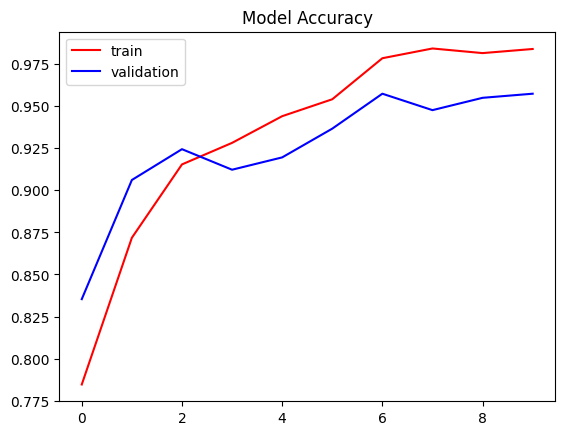

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], color='red', label='train')
plt.plot(history.history['val_accuracy'], color='blue', label='validation')
plt.title('Model Accuracy')
plt.legend()
plt.show()

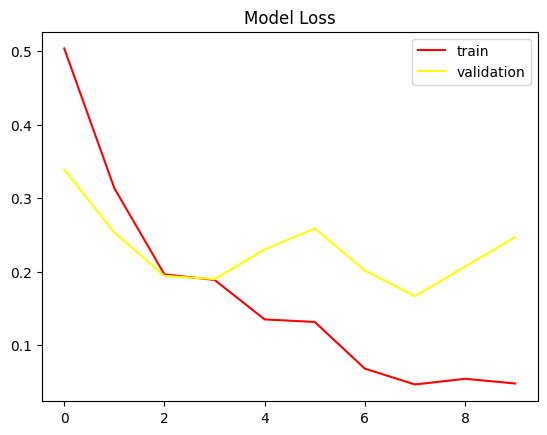

In [ ]:
plt.plot(history.history['loss'], color='red', label='train')
plt.plot(history.history['val_loss'], color='yellow', label='validation')
plt.title('Model Loss')
plt.legend()
plt.show()

In [ ]:
model.save("basic_cnn_drone_vs_bird_model.keras")

# test model

In [ ]:
import cv2
import numpy as np

In [ ]:
bird = cv2.imread('/content/dataset/bird/100.jpg')
drone = cv2.imread('/content/dataset/drone/000000000000.jpg')

print("Bird Image Size:", bird.shape)
print("Drone Image Size:", drone.shape)

Bird Image Size: (375, 500, 3)
Drone Image Size: (403, 600, 3)


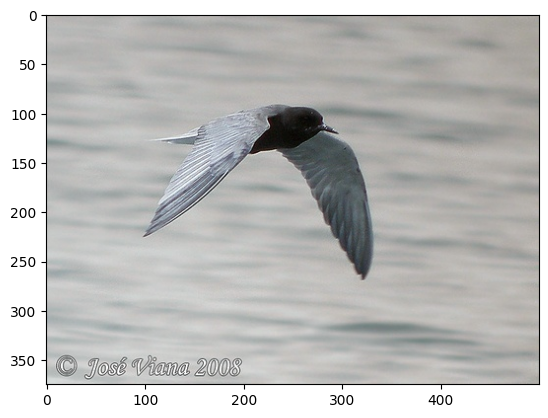

In [ ]:
plt.imshow(bird)

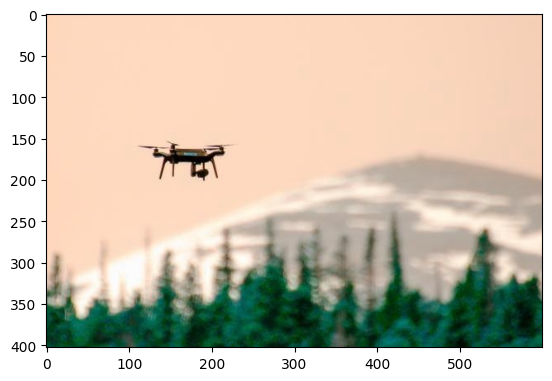

In [ ]:
plt.imshow(drone)

In [ ]:
bird = cv2.resize(bird, (224,224))
drone = cv2.resize(drone, (224,224))

print("Bird Image Size:", bird.shape)
print("Drone Image Size:", drone.shape)


Bird Image Size: (224, 224, 3)
Drone Image Size: (224, 224, 3)


In [ ]:
bird_input = bird.reshape((1,224,224,3))
drone_input = drone.reshape((1,224,224,3))

In [ ]:
print('Bird -->',model.predict(bird_input))
print('Drone -->', model.predict(drone_input))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step
Bird --> [[0.]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
Drone --> [[0.]]


In [ ]:
pred = model.predict(img)
print(float(pred[0][0]))
print(f"{pred[0][0]:.8f}")


In [ ]:
model.predict(drone_input)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


array([[0.]], dtype=float32)

In [ ]:
IMG_SIZE = (224,224)

def prepare_image(img_path):
    img = cv2.imread(img_path)
    img = cv2.resize(img, IMG_SIZE)
    img = img / 255.0
    img = np.expand_dims(img, axis=0)
    return img

img = prepare_image("/content/dataset/bird/100.jpg")
# img = prepare_image("/content/dataset/drone/000000000000.jpg")
pred = model.predict(img)[0][0]

label = "Drone" if pred > 0.5 else "Bird"
confidence = pred if pred > 0.5 else 1 - pred

print(f"Prediction: {label} | Confidence: {confidence:.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
Prediction: Drone | Confidence: 0.93


## The above plot it is clear indication for Overfitting.

## Here are the ways to reduce Overfitting.

##1. Add more data
##2. Data Augmentation
##3. L1/L2 Regularizer
##4. Dropout
##5. Batch Norm
##6. Reduce complexity

# using Dropout & Batch Norm to reduce overfitting.

In [ ]:
model = Sequential()

model.add(Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=(224,224,3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(128, kernel_size=(3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.1))                  # 10% neurons are randomly turned OFF during training.
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 52, 52, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,178,177 (42.64 MB)

 Trainable params: 11,177,729 (42.64 MB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
%%time
history2 = model.fit(train_ds, epochs=5, validation_data= validation_ds)

Epoch 1/5
103/103 ━━━━━━━━━━━━━━━━━━━━ 703s 7s/step - accuracy: 0.7871 - loss: 4.0847 - val_accuracy: 0.6817 - val_loss: 3.2272
Epoch 2/5
103/103 ━━━━━━━━━━━━━━━━━━━━ 662s 6s/step - accuracy: 0.8568 - loss: 1.9626 - val_accuracy: 0.6829 - val_loss: 5.1659
Epoch 3/5
103/103 ━━━━━━━━━━━━━━━━━━━━ 652s 6s/step - accuracy: 0.9073 - loss: 0.6456 - val_accuracy: 0.7610 - val_loss: 1.1460
Epoch 4/5
103/103 ━━━━━━━━━━━━━━━━━━━━ 656s 6s/step - accuracy: 0.9245 - loss: 0.4420 - val_accuracy: 0.8293 - val_loss: 0.7505
Epoch 5/5
103/103 ━━━━━━━━━━━━━━━━━━━━ 653s 6s/step - accuracy: 0.9439 - loss: 0.2412 - val_accuracy: 0.8634 - val_loss: 0.8342
CPU times: user 1h 9min 36s, sys: 19min 44s, total: 1h 29min 21s
Wall time: 55min 26s


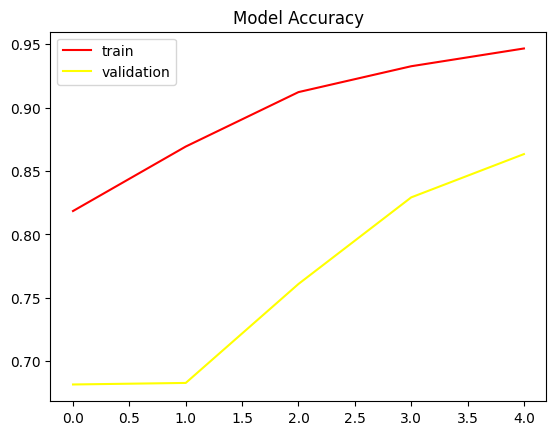

In [ ]:
plt.plot(history2.history['accuracy'], color='red', label='train')
plt.plot(history2.history['val_accuracy'], color='yellow', label='validation')
plt.title('Model Accuracy')
plt.legend()
plt.show()

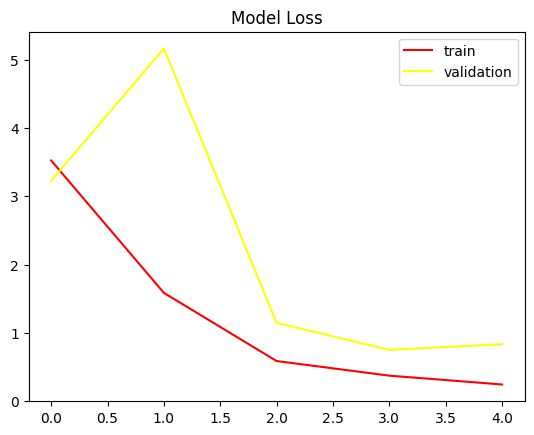

In [ ]:
plt.plot(history2.history['loss'], color='red', label='train')
plt.plot(history2.history['val_loss'], color='yellow', label='validation')
plt.title('Model Loss')
plt.legend()
plt.show()

# test model

In [ ]:
import cv2
import numpy as np

In [ ]:
IMG_SIZE = (224,224)

def prepare_image(img_path):
    img = cv2.imread(img_path)
    img = cv2.resize(img, IMG_SIZE)
    img = img / 255.0
    img = np.expand_dims(img, axis=0)
    return img

# img = prepare_image("1.JPEG")
# img = prepare_image("/content/dataset/bird/100.jpg")
# img = prepare_image("/content/dataset/drone/000000000000.jpg")
pred = model.predict(img)[0][0]

label = "Drone" if pred > 0.5 else "Bird"
confidence = pred if pred > 0.5 else 1 - pred

print(f"Prediction: {label} | Confidence: {confidence:.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
Prediction: Bird | Confidence: 0.99


In [ ]:
bird = cv2.imread('/content/singleBirdinsky58.jpeg')
drone = cv2.imread('/content/1.JPEG')

print("Bird Image Size:", bird.shape)
print("Drone Image Size:", drone.shape)

Bird Image Size: (196, 257, 3)
Drone Image Size: (721, 1200, 3)


In [ ]:
bird = cv2.resize(bird, (224,224))
drone = cv2.resize(drone, (224,224))

print("Bird Image Size:", bird.shape)
print("Drone Image Size:", drone.shape)


Bird Image Size: (224, 224, 3)
Drone Image Size: (224, 224, 3)


In [ ]:
# Reshape images
bird_input = bird.reshape((1,224,224,3))
drone_input = drone.reshape((1,224,224,3))

In [ ]:
print('Bird --> ', model.predict(bird_input))
print('-'*20)
print('Drone --> ', model.predict(drone_input))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 504ms/step
Bird -->  [[0.]]
--------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Drone -->  [[0.]]


In [ ]:
# model.save("bird_drone_cnn_model")

In [ ]:
# 1️⃣ Improve accuracy (BatchNorm + Dropout)
# 2️⃣ Data augmentation
# 3️⃣ Confusion matrix + predictions
# 4️⃣ Transfer learning (MobileNet)
# 5️⃣ Drone vs Bird video detection pipeline

#**Data Augmentation**

#STEP 1: Imports

In [ ]:
import tensorflow
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, BatchNormalization, Dropout
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
import matplotlib.pyplot as plt

# STEP 2: Create ImageDataGenerator

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,          # Normalize pixels
    rotation_range=20,       # Rotate images
    zoom_range=0.2,          # Zoom in/out
    width_shift_range=0.1,   # Horizontal shift
    height_shift_range=0.1,  # Vertical shift
    horizontal_flip=True,    # Flip images
    validation_split=0.2     # 80% train / 20% validation
)

In [ ]:
val_datagen = ImageDataGenerator(
    rescale = 1./255,
    validation_split = 0.2
)

# STEP 3: Load the training and validation datasets

In [ ]:
train_ds = train_datagen.flow_from_directory(
    directory = "/content/dataset",
    target_size = (224,224),
    batch_size = 32,
    class_mode = 'binary',
    subset = 'training',
    seed = 123
)

val_ds = val_datagen.flow_from_directory(
    directory = "/content/dataset",
    target_size = (224,224),
    batch_size = 32,
    class_mode = 'binary',
    subset = 'validation',
    seed = 123
)

Found 3284 images belonging to 2 classes.
Found 820 images belonging to 2 classes.


In [ ]:
print(train_ds.class_indices)

{'bird': 0, 'drone': 1}


#STEP 4: Build CNN Model

In [ ]:
model = Sequential()

model.add(Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=(224,224,3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64, (3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2,2))

model.add(Conv2D(128, (3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2,2))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.1))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.1))

model.add(Dense(1, activation='sigmoid'))

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 52, 52, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,178,177 (42.64 MB)

 Trainable params: 11,177,729 (42.64 MB)

 Non-trainable params: 448 (1.75 KB)

#STEP 5: Compile Model

In [ ]:
model.compile(loss = 'binary_crossentropy', optimizer='adam', metrics=['accuracy'])

#STEP 6: Train Model

In [ ]:
%%time
history = model.fit(train_ds, epochs=5, validation_data=val_ds)

#STEP 7: Plot Accuracy & Loss

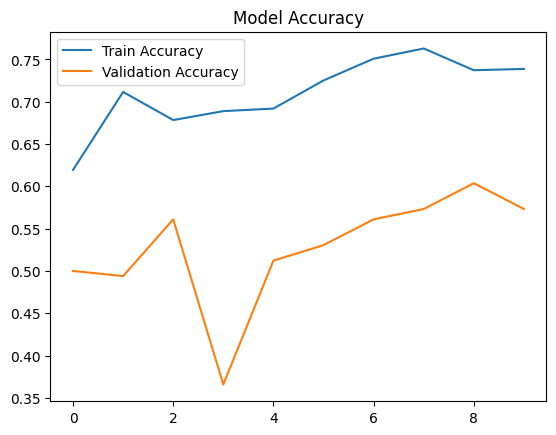

In [ ]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title("Model Accuracy")
plt.show()


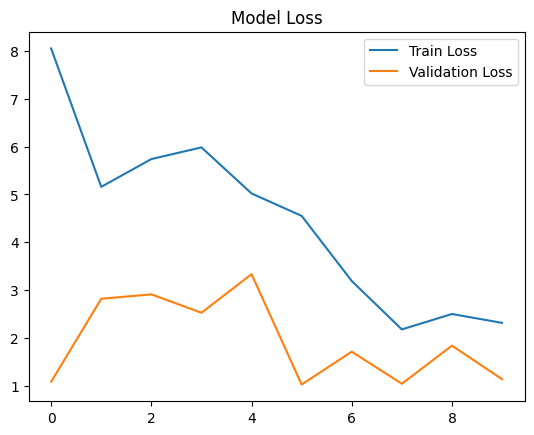

In [ ]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title("Model Loss")
plt.show()


#STEP 9: Predict on Single Image

In [ ]:
import cv2
import numpy as np

IMG_SIZE = (224,224)

def prepare_image(img_path):
    img = cv2.imread(img_path)
    img = cv2.resize(img, IMG_SIZE)
    img = img / 255.0
    img = np.expand_dims(img, axis=0)
    return img

img = prepare_image("/content/1.JPEG")
pred = model.predict(img)[0][0]

label = "Drone" if pred > 0.5 else "Bird"
confidence = pred if pred > 0.5 else 1 - pred

print(f"Prediction: {label} | Confidence: {confidence:.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 538ms/step
Prediction: Bird | Confidence: 0.87


---
# NEW DATA AUGMENTATION (MODERN WAY)
* Uses: tf.keras.layers
* Works inside the model
* Saved automatically with model
---

#STEP 1: Imports

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.models import Sequential
import matplotlib.pyplot as plt


#STEP 2: Load Dataset

In [ ]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
SEED = 123

train_ds = keras.utils.image_dataset_from_directory(
    "/content/drive/MyDrive/BirdVsDrone",
    validation_split=0.2,
    subset="training",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

val_ds = keras.utils.image_dataset_from_directory(
    "/content/drive/MyDrive/BirdVsDrone",
    validation_split=0.2,
    subset="validation",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

class_names = train_ds.class_names
print("Classes:", class_names)


Found 826 files belonging to 2 classes.
Using 661 files for training.
Found 826 files belonging to 2 classes.
Using 165 files for validation.
Classes: ['Birds', 'Drones']


# STEP 3: Normalize Images

In [ ]:
def normalize(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

train_ds = train_ds.map(normalize)
val_ds = val_ds.map(normalize)


#STEP 4: NEW DATA AUGMENTATION


In [ ]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
])


#STEP 5: Performance Optimization


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(AUTOTUNE)
val_ds = val_ds.prefetch(AUTOTUNE)


#STEP 6: CNN MODEL


In [ ]:
model = Sequential([

    data_augmentation,  # 🔥 FIRST layer

    layers.Conv2D(32, (3,3), activation='relu', input_shape=(224,224,3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(128, (3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2,2),

    layers.Flatten(),

    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),

    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),

    layers.Dense(1, activation='sigmoid')
])


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


#STEP 7: Compile Model


In [ ]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_3 (Sequential)       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

#STEP 8: Train Model

In [ ]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5
)


Epoch 1/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 16s 276ms/step - accuracy: 0.6431 - loss: 7.2298 - val_accuracy: 0.5333 - val_loss: 0.9382
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 234ms/step - accuracy: 0.6593 - loss: 9.5334 - val_accuracy: 0.5091 - val_loss: 6.0612
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 8s 359ms/step - accuracy: 0.6853 - loss: 9.8424 - val_accuracy: 0.4848 - val_loss: 1.9933
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 7s 319ms/step - accuracy: 0.6696 - loss: 6.2319 - val_accuracy: 0.5455 - val_loss: 1.1146
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 9s 411ms/step - accuracy: 0.6950 - loss: 4.8885 - val_accuracy: 0.5030 - val_loss: 1.0204
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 7s 229ms/step - accuracy: 0.7485 - loss: 3.2093 - val_accuracy: 0.5212 - val_loss: 2.8956
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 292ms/step - accuracy: 0.6937 - loss: 4.6099 - val_accuracy: 0.5333 - val_loss: 3.2335
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 9s 243ms/step - accuracy: 0.6984 - loss: 3.8192 - val_accuracy: 0

#STEP 9: Plot Results

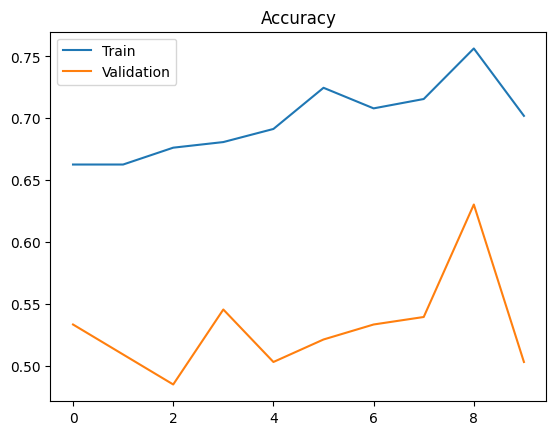

In [ ]:
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title("Accuracy")
plt.legend()
plt.show()


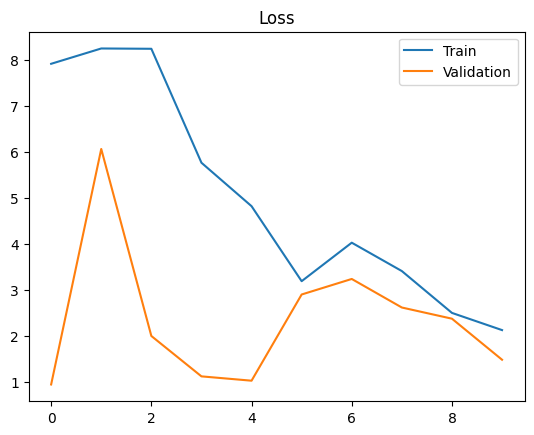

In [ ]:
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title("Loss")
plt.legend()
plt.show()


# test model

In [ ]:
import cv2
import numpy as np

In [ ]:
bird = cv2.imread('/content/singleBirdinsky58.jpeg')
drone = cv2.imread('/content/1.JPEG')

print("Bird Image Size:", bird.shape)
print("Drone Image Size:", drone.shape)

Bird Image Size: (196, 257, 3)
Drone Image Size: (721, 1200, 3)


In [ ]:
bird = cv2.resize(bird, (224,224))
drone = cv2.resize(drone, (224,224))

print("Bird Image Size:", bird.shape)
print("Drone Image Size:", drone.shape)


Bird Image Size: (224, 224, 3)
Drone Image Size: (224, 224, 3)


In [ ]:
# Reshape images
bird_input = bird.reshape((1,224,224,3))
drone_input = drone.reshape((1,224,224,3))

In [ ]:
print('Bird --> ', model.predict(bird_input))
print('-'*20)
print('Drone --> ', model.predict(drone_input))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step
Bird -->  [[0.]]
--------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Drone -->  [[0.]]


---
# Transfer Learning
---

# Setup Kaggle in Colab

In [1]:
!mkdir -p ~/.kaggle
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

#  Download Dataset & Unzip:

In [2]:
!kaggle datasets download -d muhammadsaoodsarwar/drone-vs-bird -p ./ --unzip

Dataset URL: https://www.kaggle.com/datasets/muhammadsaoodsarwar/drone-vs-bird
License(s): apache-2.0
100% 1.59G/1.59G [00:13<00:00, 269MB/s]
100% 1.59G/1.59G [00:13<00:00, 124MB/s]


---
#STEP 1: Import Libraries
---

In [3]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from collections import Counter

from keras.applications.mobilenet_v2 import preprocess_input

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Dropout
from keras import layers
from keras.applications import MobileNetV2
from keras.metrics import F1Score
from keras.callbacks import EarlyStopping, ReduceLROnPlateau


# Conv2D --> Applies convolution filters to extract image features (edges, shapes).
# MaxPool2D --> Reduces image size while keeping important information.
# Flatten --> Converts 2D feature maps → 1D vector for Dense layers.
# Dense --> Fully connected layers.

---
# Check the Image Formats
---

In [4]:
def count_images(pathdir):
    counter = Counter()   # 1
    total = 0

    for subdir, _, files in os.walk(pathdir):  # 2
        for f in files:
            ext = os.path.splitext(f)[1].lower()   # 3
            if ext in ['.jpg', '.jpeg', '.png', '.webp', '.gif', '.bmp']:
                counter[ext] += 1
                total += 1

    print("Total images:", total)
    print(counter)

count_images("/content/dataset")


# comments
# 1. --> "Counter" → It counts how many .jpg files, .jpeg, .png files are there
# 2. --> "subdir" → the current folder it’s looking at.
#    --> "_" → a placeholder for subfolders.
#    --> "files" → a list of all files in the current folder.
# 3. -->  os.path.splitext(f) → splits the file name into:
#         i)-> "name" → cat.jpg → cat.
#         ii)-> "extension" → cat.jpg → .jpg.
#         iii) [1] → we only take the extension.
#         iv) "lower()" → converts .JPG into .jpg

Total images: 4106
Counter({'.jpg': 3278, '.jpeg': 778, '.png': 48, '.webp': 2})


---
# Remove webp
---

In [5]:
def remove_webp(root_folder):
    """Remove all WebP files from dataset recursively"""
    removed = 0

    for subdir, _, files in os.walk(root_folder):
        for f in files:
            if f.lower().endswith('.webp'):
                webp_path = os.path.join(subdir, f)
                os.remove(webp_path)
                removed += 1
                print(f" Removed: {webp_path}")

    print(f"\n Total WebP files Removed: {removed}")



# Run the function
remove_webp("/content/dataset")

 Removed: /content/dataset/bird/singleBirdinsky18.webp
 Removed: /content/dataset/bird/singleBirdinsky19.webp

 Total WebP files Removed: 2


---
# Fix Corrupt Images
---

In [6]:
import os
from PIL import Image

dataset_path = "/content/dataset"

fixed = 0
deleted = 0

for root, _, files in os.walk(dataset_path):
  for f in files:
    file_path = os.path.join(root, f)

    if f.lower().endswith(('.jpg', '.jpeg', '.png')):
      try:
        img = Image.open(file_path)
        img.save(file_path, "JPEG", quality=95, subsampling=0)
        fixed += 1

      except Exception:
        os.remove(file_path)
        deleted += 1

print("Fixed images:", fixed)
print("Deleted unreadable images:", deleted)

Fixed images: 4101
Deleted unreadable images: 3


---
# STEP 2: Load Dataset
---

In [7]:
train_ds = keras.utils.image_dataset_from_directory(
    directory = "/content/dataset",
    validation_split = 0.2,         # 20% for validation
    subset = "training",            # Take 80% for training
    label_mode = "int",             # Returns integer labels (0,1)
    batch_size = 32,
    image_size = (224,224),
    seed = 123
)

validation_ds = keras.utils.image_dataset_from_directory(
    directory = "/content/dataset",
    validation_split = 0.2,
    subset = "validation",         # Take 20% for validation
    label_mode = "int",
    batch_size = 32,              # the model it processes images in batches.
    image_size = (224,224),
    seed = 123
)

print("Classes:", train_ds.class_names)


Found 4101 files belonging to 2 classes.
Using 3281 files for training.
Found 4101 files belonging to 2 classes.
Using 820 files for validation.
Classes: ['bird', 'drone']


---
# STEP 3: Preprocessing (MobileNetV2)
---

In [8]:
def preprocess(image, label):
    image = preprocess_input(image)
    return image, label

# Apply normalization to datasets:
train_ds = train_ds.map(preprocess, num_parallel_calls= tf.data.AUTOTUNE)
validation_ds = validation_ds.map(preprocess, num_parallel_calls= tf.data.AUTOTUNE)


---
#STEP 4: OPTIMIZE PERFORMANCE (prefetch)
---
* for Faster training.
* When to Use:
  * Dataset is large. (10k-50k)
  * Transfer learning.
  * Video frames.

In [11]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size= AUTOTUNE)
validation_ds = validation_ds.prefetch(buffer_size= AUTOTUNE)

---
#STEP 5: Add Augmentation Using `Keras Preprocessing Layers` --> runs on GPU.
---

## `ImageDataGenerator` --> which runs on the CPU.
---
## Why is it Imp?
* Makes model robust.
* Prevents overfitting.


In [9]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.2)
])

def augment(image, label):
    image = data_augmentation(image, training=True)
    return image, label

train_ds = train_ds.map(augment, num_parallel_calls=tf.data.AUTOTUNE)

---
# STEP 6: Load Pretrained Model -> MobileNetV2 (Transfer Learning)
---

In [12]:
conv_base = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(224,224,3)
)

# here we freezing conv(not changing anything in MobileNetV2 conv part)
conv_base.trainable = False

conv_base.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "mobilenetv2_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

---
# STEP 7: Build Model
---
## Global Average Pooling:
* Fewer parameters
* Less overfitting
* Better generalization

In [13]:

inputs = keras.Input(shape=(224, 224, 3))

x = conv_base(inputs, training= False)
x = layers.GlobalAveragePooling2D()(x)

x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.3)(x)

outputs = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs, outputs)
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,586,177 (9.87 MB)

 Trainable params: 328,193 (1.25 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

---
# STEP 8: Compile Model
---

In [14]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy",
             keras.metrics.Precision(name="precision"),
             keras.metrics.Recall(name="recall"),
             keras.metrics.AUC(name="auc")
             ]
)

# STEP 9: Add EarlyStopping

In [15]:
callback = EarlyStopping(
    monitor = 'val_loss',
    patience = 5,                # Stop after 5 epochs no improvement
    restore_best_weights=True,   # Revert to best model
    verbose=1
)

# It automatically reduces the learning rate when your model stops improving.
# Dynamically adjusts the learning rate if the model gets "stuck".
lr_scheduler = ReduceLROnPlateau(
    monitor = 'val_loss',
    factor = 0.2,
    patience = 3,
    min_lr = 1e-6,
    verbose=1
)

# STEP 10: Train Model

In [16]:
%%time
history = model.fit(train_ds,
                    epochs = 35,
                    validation_data = validation_ds,
                    callbacks= [callback, lr_scheduler])


Epoch 1/35
103/103 ━━━━━━━━━━━━━━━━━━━━ 118s 909ms/step - accuracy: 0.7513 - auc: 0.8052 - loss: 0.4909 - precision: 0.7667 - recall: 0.8588 - val_accuracy: 0.9037 - val_auc: 0.9897 - val_loss: 0.2215 - val_precision: 0.8689 - val_recall: 0.9920 - learning_rate: 1.0000e-04
Epoch 2/35
103/103 ━━━━━━━━━━━━━━━━━━━━ 72s 688ms/step - accuracy: 0.9286 - auc: 0.9773 - loss: 0.1995 - precision: 0.9298 - recall: 0.9564 - val_accuracy: 0.9427 - val_auc: 0.9924 - val_loss: 0.1555 - val_precision: 0.9235 - val_recall: 0.9880 - learning_rate: 1.0000e-04
Epoch 3/35
103/103 ━━━━━━━━━━━━━━━━━━━━ 70s 676ms/step - accuracy: 0.9431 - auc: 0.9848 - loss: 0.1597 - precision: 0.9515 - recall: 0.9561 - val_accuracy: 0.9317 - val_auc: 0.9921 - val_loss: 0.1675 - val_precision: 0.9053 - val_recall: 0.9920 - learning_rate: 1.0000e-04
Epoch 4/35
103/103 ━━━━━━━━━━━━━━━━━━━━ 69s 670ms/step - accuracy: 0.9541 - auc: 0.9925 - loss: 0.1198 - precision: 0.9542 - recall: 0.9714 - val_accuracy: 0.9354 - val_auc: 0.9942

In [ ]:
"""
Epoch 1/35
103/103 ━━━━━━━━━━━━━━━━━━━━ 266s 2s/step - accuracy: 0.7596 - auc: 0.8448 - loss: 0.4795 - precision: 0.8364 - recall: 0.7503 - val_accuracy: 0.9146 - val_auc: 0.9885 - val_loss: 0.2231 - val_precision: 0.8841 - val_recall: 0.9900 - learning_rate: 1.0000e-04
Epoch 2/35
103/103 ━━━━━━━━━━━━━━━━━━━━ 289s 3s/step - accuracy: 0.9224 - auc: 0.9750 - loss: 0.1975 - precision: 0.9385 - recall: 0.9350 - val_accuracy: 0.9463 - val_auc: 0.9924 - val_loss: 0.1496 - val_precision: 0.9271 - val_recall: 0.9900 - learning_rate: 1.0000e-04
Epoch 3/35
103/103 ━━━━━━━━━━━━━━━━━━━━ 289s 3s/step - accuracy: 0.9414 - auc: 0.9878 - loss: 0.1428 - precision: 0.9569 - recall: 0.9478 - val_accuracy: 0.9585 - val_auc: 0.9932 - val_loss: 0.1195 - val_precision: 0.9465 - val_recall: 0.9880 - learning_rate: 1.0000e-04
Epoch 4/35
103/103 ━━━━━━━━━━━━━━━━━━━━ 290s 3s/step - accuracy: 0.9590 - auc: 0.9888 - loss: 0.1208 - precision: 0.9642 - recall: 0.9685 - val_accuracy: 0.9585 - val_auc: 0.9952 - val_loss: 0.1123 - val_precision: 0.9465 - val_recall: 0.9880 - learning_rate: 1.0000e-04
Epoch 5/35
103/103 ━━━━━━━━━━━━━━━━━━━━ 250s 2s/step - accuracy: 0.9622 - auc: 0.9927 - loss: 0.1060 - precision: 0.9710 - recall: 0.9666 - val_accuracy: 0.9598 - val_auc: 0.9954 - val_loss: 0.1140 - val_precision: 0.9483 - val_recall: 0.9880 - learning_rate: 1.0000e-04
Epoch 6/35
103/103 ━━━━━━━━━━━━━━━━━━━━ 250s 2s/step - accuracy: 0.9721 - auc: 0.9958 - loss: 0.0833 - precision: 0.9750 - recall: 0.9791 - val_accuracy: 0.9634 - val_auc: 0.9963 - val_loss: 0.1004 - val_precision: 0.9538 - val_recall: 0.9880 - learning_rate: 1.0000e-04
Epoch 7/35
103/103 ━━━━━━━━━━━━━━━━━━━━ 255s 2s/step - accuracy: 0.9731 - auc: 0.9951 - loss: 0.0836 - precision: 0.9745 - recall: 0.9819 - val_accuracy: 0.9634 - val_auc: 0.9964 - val_loss: 0.0902 - val_precision: 0.9555 - val_recall: 0.9860 - learning_rate: 1.0000e-04
Epoch 8/35
103/103 ━━━━━━━━━━━━━━━━━━━━ 267s 3s/step - accuracy: 0.9846 - auc: 0.9972 - loss: 0.0639 - precision: 0.9883 - recall: 0.9863 - val_accuracy: 0.9610 - val_auc: 0.9963 - val_loss: 0.0979 - val_precision: 0.9518 - val_recall: 0.9860 - learning_rate: 1.0000e-04
Epoch 9/35
103/103 ━━━━━━━━━━━━━━━━━━━━ 292s 3s/step - accuracy: 0.9706 - auc: 0.9962 - loss: 0.0786 - precision: 0.9728 - recall: 0.9795 - val_accuracy: 0.9646 - val_auc: 0.9963 - val_loss: 0.0934 - val_precision: 0.9574 - val_recall: 0.9860 - learning_rate: 1.0000e-04
Epoch 10/35
103/103 ━━━━━━━━━━━━━━━━━━━━ 294s 3s/step - accuracy: 0.9727 - auc: 0.9966 - loss: 0.0705 - precision: 0.9799 - recall: 0.9746 - val_accuracy: 0.9671 - val_auc: 0.9967 - val_loss: 0.0874 - val_precision: 0.9593 - val_recall: 0.9880 - learning_rate: 1.0000e-04
Epoch 11/35
103/103 ━━━━━━━━━━━━━━━━━━━━ 296s 3s/step - accuracy: 0.9810 - auc: 0.9982 - loss: 0.0570 - precision: 0.9809 - recall: 0.9881 - val_accuracy: 0.9744 - val_auc: 0.9968 - val_loss: 0.0781 - val_precision: 0.9706 - val_recall: 0.9880 - learning_rate: 1.0000e-04
Epoch 12/35
103/103 ━━━━━━━━━━━━━━━━━━━━ 253s 2s/step - accuracy: 0.9869 - auc: 0.9979 - loss: 0.0558 - precision: 0.9889 - recall: 0.9895 - val_accuracy: 0.9671 - val_auc: 0.9967 - val_loss: 0.0862 - val_precision: 0.9593 - val_recall: 0.9880 - learning_rate: 1.0000e-04
Epoch 13/35
103/103 ━━━━━━━━━━━━━━━━━━━━ 256s 2s/step - accuracy: 0.9835 - auc: 0.9989 - loss: 0.0471 - precision: 0.9868 - recall: 0.9861 - val_accuracy: 0.9646 - val_auc: 0.9965 - val_loss: 0.0876 - val_precision: 0.9574 - val_recall: 0.9860 - learning_rate: 1.0000e-04
Epoch 14/35
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9845 - auc: 0.9990 - loss: 0.0434 - precision: 0.9875 - recall: 0.9872
Epoch 14: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
103/103 ━━━━━━━━━━━━━━━━━━━━ 292s 3s/step - accuracy: 0.9845 - auc: 0.9990 - loss: 0.0434 - precision: 0.9875 - recall: 0.9872 - val_accuracy: 0.9683 - val_auc: 0.9968 - val_loss: 0.0857 - val_precision: 0.9612 - val_recall: 0.9880 - learning_rate: 1.0000e-04
Epoch 15/35
103/103 ━━━━━━━━━━━━━━━━━━━━ 256s 2s/step - accuracy: 0.9821 - auc: 0.9981 - loss: 0.0556 - precision: 0.9842 - recall: 0.9865 - val_accuracy: 0.9683 - val_auc: 0.9969 - val_loss: 0.0824 - val_precision: 0.9612 - val_recall: 0.9880 - learning_rate: 2.0000e-05
Epoch 16/35
103/103 ━━━━━━━━━━━━━━━━━━━━ 267s 3s/step - accuracy: 0.9861 - auc: 0.9991 - loss: 0.0406 - precision: 0.9857 - recall: 0.9917 - val_accuracy: 0.9695 - val_auc: 0.9968 - val_loss: 0.0794 - val_precision: 0.9630 - val_recall: 0.9880 - learning_rate: 2.0000e-05
Epoch 16: early stopping
Restoring model weights from the end of the best epoch: 11.
CPU times: user 1h 34min 1s, sys: 16min 58s, total: 1h 51min
Wall time: 1h 12min 41s

26/26 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - accuracy: 0.9702 - auc: 0.9959 - loss: 0.0908 - precision: 0.9667 - recall: 0.9840
Validation Loss: 0.0781
Validation Accuracy: 0.9744
Validation Precision: 0.9706
Validation Recall: 0.9880
Validation AUC: 0.9968

"""

In [17]:
loss, acc, prec, rec, auc_score = model.evaluate(validation_ds)
print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {acc:.4f}")
print(f"Validation Precision: {prec:.4f}")
print(f"Validation Recall: {rec:.4f}")
print(f"Validation AUC: {auc_score:.4f}")

26/26 ━━━━━━━━━━━━━━━━━━━━ 8s 289ms/step - accuracy: 0.9492 - auc: 0.9932 - loss: 0.1264 - precision: 0.9394 - recall: 0.9797
Validation Loss: 0.1168
Validation Accuracy: 0.9537
Validation Precision: 0.9426
Validation Recall: 0.9840
Validation AUC: 0.9947


# STEP 11: Plot Results

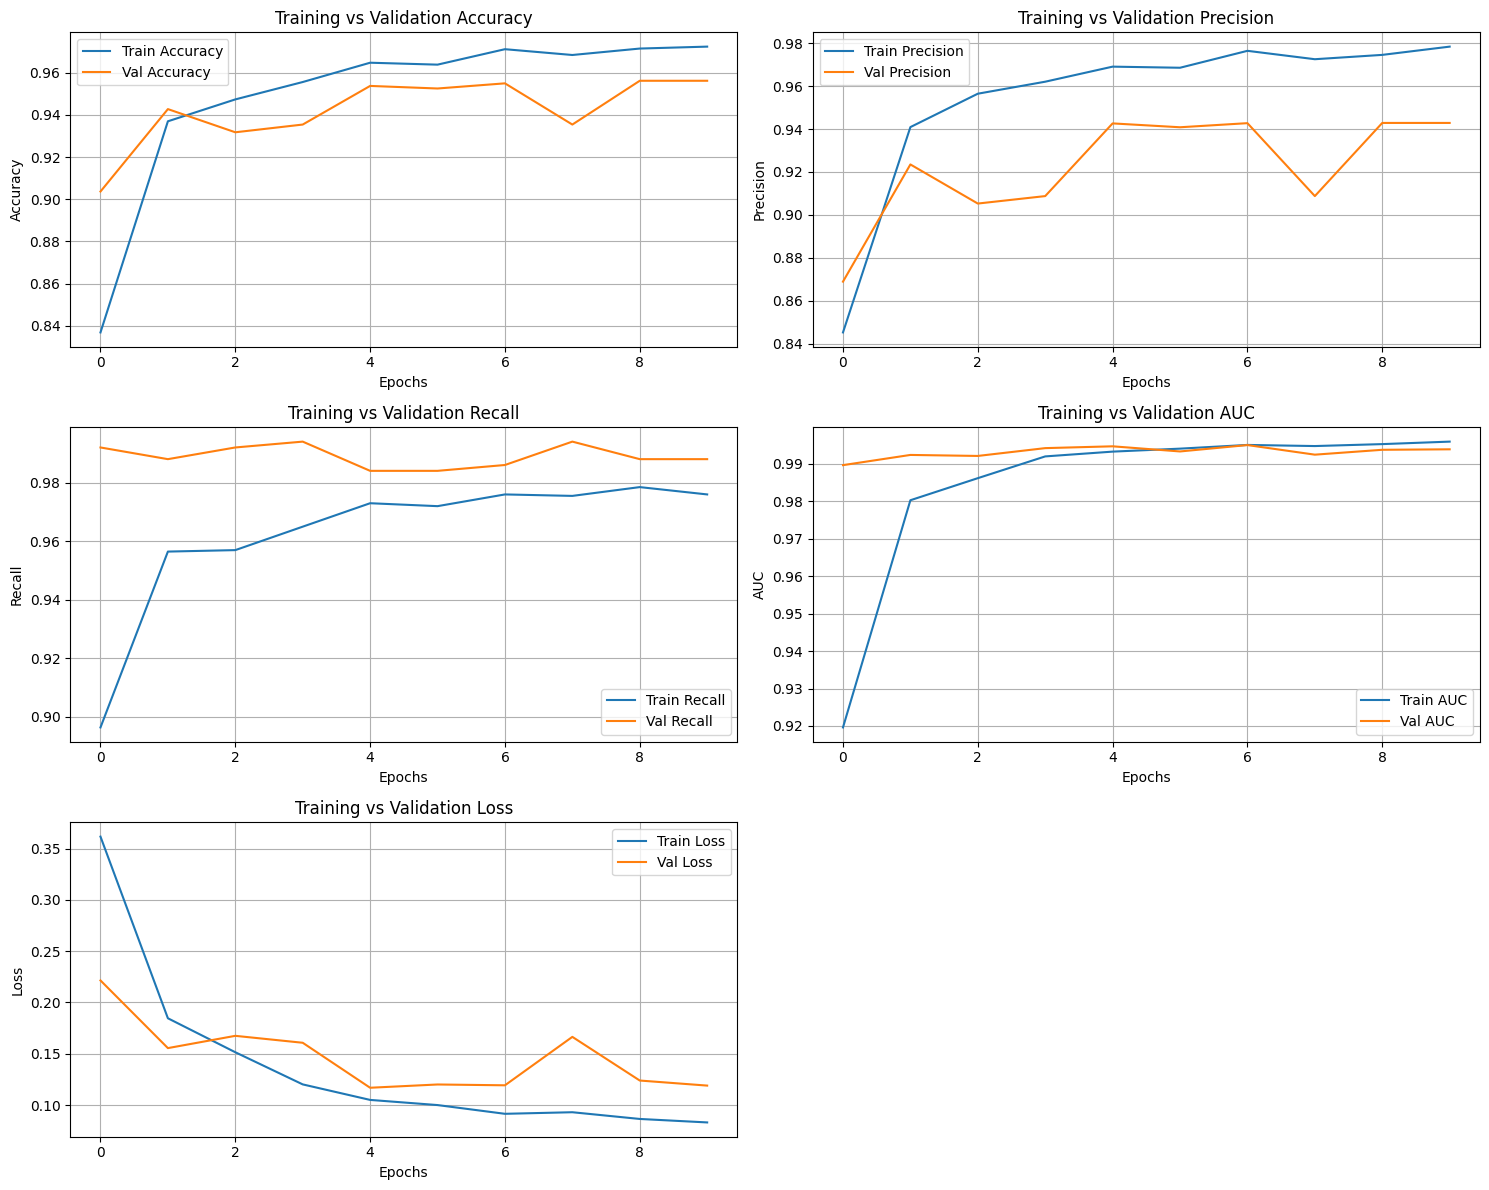

In [18]:
import matplotlib.pyplot as plt

def plot_metrics(history):
    metrics = [
        ("accuracy", "Accuracy"),
        ("precision", "Precision"),
        ("recall", "Recall"),
        ("auc", "AUC"),
        ("loss", "Loss")
    ]

    plt.figure(figsize=(15, 12))

    for i, (metric, title) in enumerate(metrics, 1):
        plt.subplot(3, 2, i)

        plt.plot(history.history[metric], label=f"Train {title}")
        plt.plot(history.history[f"val_{metric}"], label=f"Val {title}")

        plt.xlabel("Epochs")
        plt.ylabel(title)
        plt.title(f"Training vs Validation {title}")
        plt.legend()
        plt.grid(True)

    plt.tight_layout()
    plt.show()

# Run it.
plot_metrics(history)


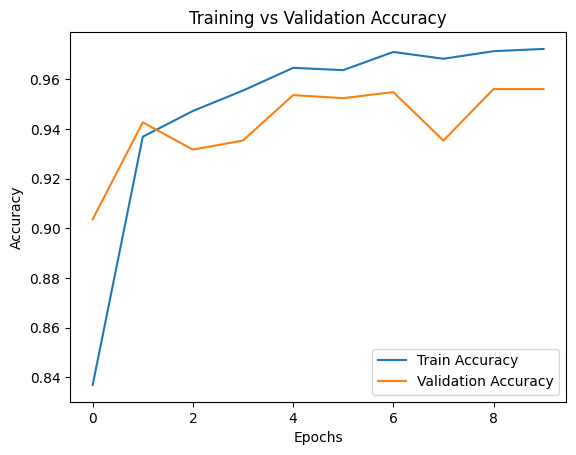

In [20]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.show()


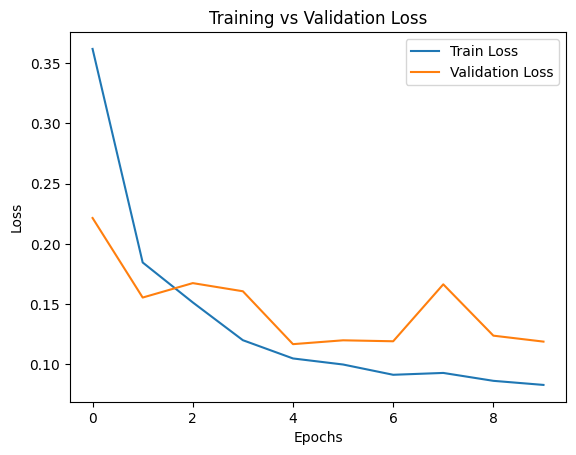

In [21]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.show()


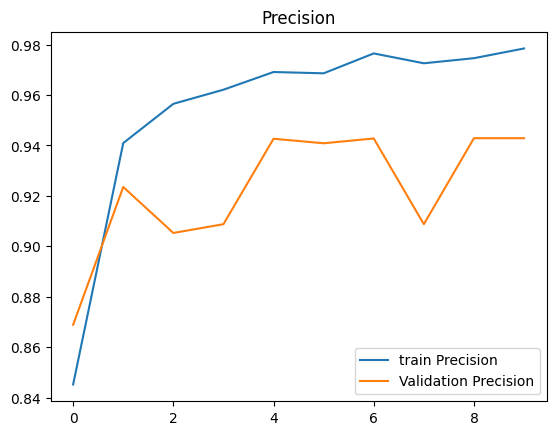

In [22]:
plt.plot(history.history['precision'], label='train Precision')
plt.plot(history.history['val_precision'], label='Validation Precision')
plt.title("Precision")
plt.legend()
plt.show()


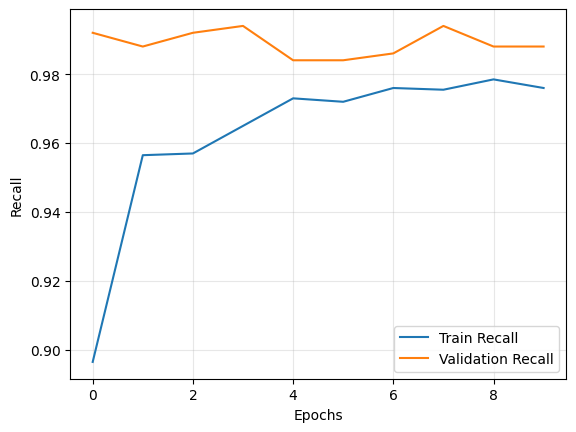

In [23]:
plt.plot(history.history['recall'], label= 'Train Recall')
plt.plot(history.history['val_recall'], label= 'Validation Recall')
plt.xlabel("Epochs")
plt.ylabel("Recall")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [28]:

IMG_SIZE = (224,224)

def prepare_image(img_path):
    img = cv2.imread(img_path)
    img = cv2.resize(img, IMG_SIZE)
    img = img / 255.0
    img = np.expand_dims(img, axis=0)
    return img

img = prepare_image("/content/dataset/bird/singleBirdinsky108_brighter.jpg")
# img = prepare_image("/content/dataset/drone/100302.jpg")
# img = prepare_image("/content/dataset/drone/000000000875.jpg")
# img = prepare_image("/content/images.jpeg")
# img = prepare_image("/content/Drone-Light-Show-2-1024x683.jpeg")
pred = model.predict(img)


print(float(pred[0][0]))



label = "Drone" if pred > 0.9 else "Bird"
confidence = pred if pred > 0.9 else 1 - pred

print(f"Prediction: {label} | Confidence: {confidence[0][0]:.3f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
0.17890289425849915
Prediction: Bird | Confidence: 0.821


In [29]:
model.save("Drone_Vs_Bird_Model.keras")

# Test the Model

In [30]:
DATASET = "/content/drive/MyDrive/BirdVsDrone"
IMG_SIZE = (224,224)
BATCH_SIZE = 32

# --- Apply image fixing to the new dataset ---
import os
from PIL import Image

fixed_count = 0
deleted_count = 0

for root, _, files in os.walk(DATASET):
  for f in files:
    file_path = os.path.join(root, f)

    if f.lower().endswith(('.jpg', '.jpeg', '.png', '.gif', '.bmp')):
      try:
        img = Image.open(file_path)
        img.save(file_path, "JPEG", quality=95, subsampling=0)
        fixed_count += 1

      except Exception:
        os.remove(file_path)
        deleted_count += 1
    elif not f.lower().endswith(('.jpg', '.jpeg', '.png', '.gif', '.bmp')):
        # Delete non-image files if any remain
        os.remove(file_path)
        deleted_count += 1
        print(f"Deleted non-image file: {file_path}")

print(f"Fixed images in {DATASET}: {fixed_count}")
print(f"Deleted unreadable/non-image files in {DATASET}: {deleted_count}")
# ----------------------------------------------


test_ds = keras.utils.image_dataset_from_directory(
    directory = DATASET,
    image_size = IMG_SIZE,
    batch_size = BATCH_SIZE,
    shuffle = False
)

test_ds = test_ds.map(lambda x,y: (preprocess_input(x), y))

Fixed images in /content/drive/MyDrive/BirdVsDrone: 826
Deleted unreadable/non-image files in /content/drive/MyDrive/BirdVsDrone: 0
Found 826 files belonging to 2 classes.


In [31]:
results = model.evaluate(test_ds)

# Explicitly define metric names in the expected order
metric_names = ['loss', 'accuracy', 'precision', 'recall', 'auc']

for name, value in zip(metric_names, results):
  print(f"{name}: {value:.4f}")

26/26 ━━━━━━━━━━━━━━━━━━━━ 20s 770ms/step - accuracy: 0.9179 - auc: 0.5495 - loss: 0.2198 - precision: 0.4531 - recall: 0.5473
loss: 0.1605
accuracy: 0.9443
precision: 0.9263
recall: 0.9696
auc: 0.9853


In [32]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

y_true, y_pred = [], []

for images, labels in test_ds:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(preds.flatten())

y_pred = (np.array(y_pred) >= 0.9).astype(int)

print(classification_report(y_true, y_pred, target_names=["Bird", "Drone"]))

cm = confusion_matrix(y_true, y_pred)
print(cm)


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
  

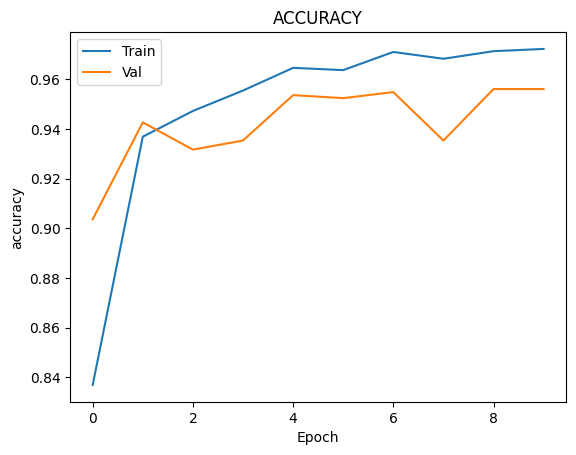

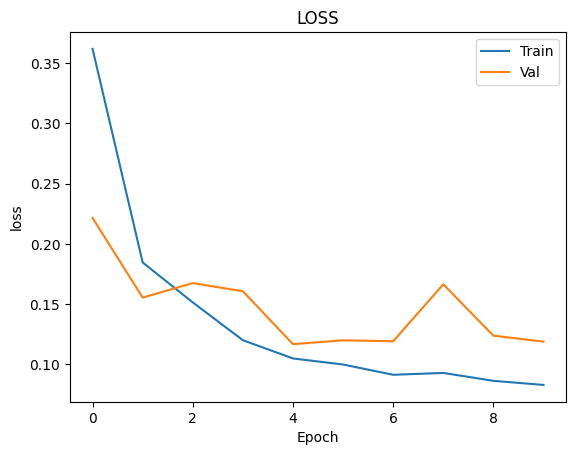

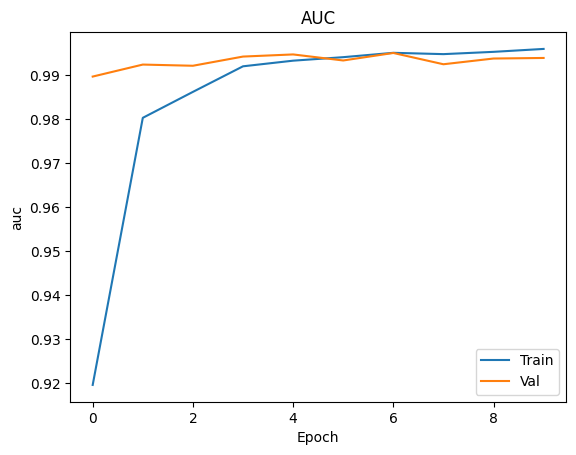

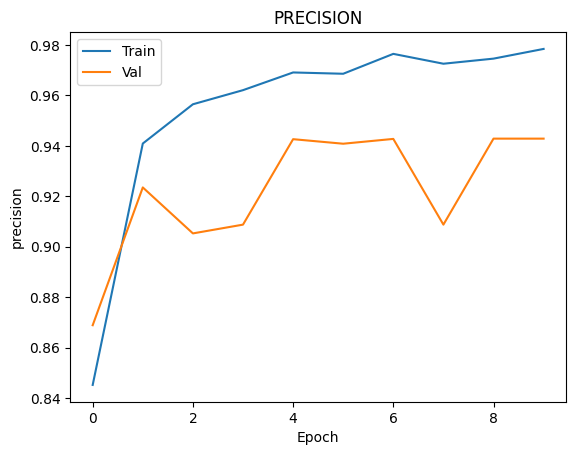

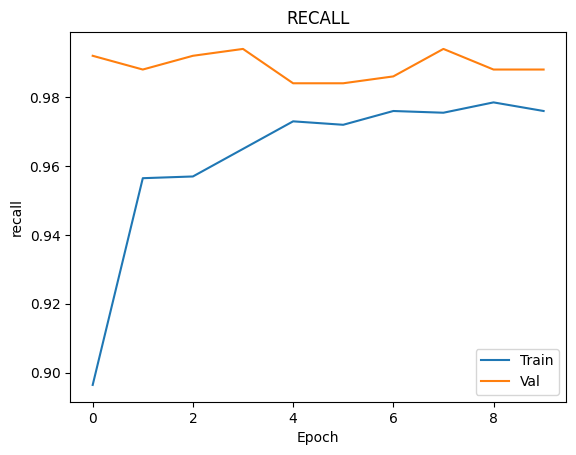

In [33]:
import matplotlib.pyplot as plt

def plot_metric(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history[f"val_{metric}"])
    plt.title(metric.upper())
    plt.xlabel("Epoch")
    plt.ylabel(metric)
    plt.legend(["Train", "Val"])
    plt.show()

plot_metric(history, "accuracy")
plot_metric(history, "loss")
plot_metric(history, "auc")
plot_metric(history, "precision")
plot_metric(history, "recall")


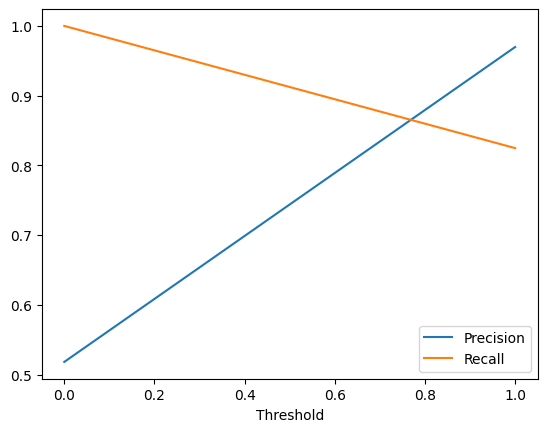

In [34]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_true, y_pred)

plt.plot(thresholds, precision[:-1], label="Precision")
plt.plot(thresholds, recall[:-1], label="Recall")
plt.xlabel("Threshold")
plt.legend()
plt.show()


In [ ]:
IMG_SIZE = (224,224)

def prepare_image(img_path):
    img = cv2.imread(img_path)
    img = cv2.resize(img, IMG_SIZE)
    img = img / 255.0
    img = np.expand_dims(img, axis=0)
    return img

img = prepare_image("/content/Drone-Light-Show-2-1024x683.jpeg") # Re-prepare the image
pred = model.predict(img)[0][0]
label = "Drone" if pred >= 0.9 else "Bird"

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


In [ ]:
# keras.models.load_model("/content/drive/MyDrive/drone_vs_bird_model.keras")
model = keras.models.load_model("/content/Drone_Vs_Bird_Model.keras")

In [ ]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,252,805 (12.41 MB)

 Trainable params: 330,753 (1.26 MB)

 Non-trainable params: 2,260,544 (8.62 MB)

 Optimizer params: 661,508 (2.52 MB)

In [ ]:
# Assuming you have a test_ds prepared similarly to your train_ds
results = model.evaluate(validation_ds)
print(f"Test Loss: {results[0]}, Test Accuracy: {results[1]}")


NameError: name 'validation_ds' is not defined

In [ ]:

IMG_SIZE = (224,224)

def prepare_image(img_path):
    img = cv2.imread(img_path)
    img = cv2.resize(img, IMG_SIZE)
    img = img / 255.0
    img = np.expand_dims(img, axis=0)
    return img

img = prepare_image("/content/drive/MyDrive/BirdVsDrone/Birds/singleBirdinsky79.jpeg")
# img = prepare_image("/content/drive/MyDrive/BirdVsDrone/Drones/singleDronesinsky366.jpeg")
pred = model.predict(img)


print(float(pred[0][0]))



label = "Drone" if pred > 0.9 else "Bird"
confidence = pred if pred > 0.9 else 1 - pred

print(f"Prediction: {label} | Confidence: {confidence[0][0]:.3f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
0.6556658148765564
Prediction: Bird | Confidence: 0.344
